### aim: 

### date: 

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 13})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 13}
plt.rcParams['text.usetex'] = True
plt.rc('font', **font)

## make 2d mfdataset of Cflx and qtrB14b


In [4]:
extract = False

def make_yearlist(yrst, yrend, dtype, tr, baseDir = '/gpfs/data/greenocean/software/runs/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/TOM12_TJ_{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def getC14ts(yrst,yrend, tr, dtype = 'diad_T', baseDir = '/gpfs/data/greenocean/software/runs/'):
    
    tdiad = xr.open_mfdataset(make_yearlist(yrst,yrend,'diad_T',tr))
    tdiad.qtrB14b.to_netcdf(f'./GCBdata/{tr}_{yrst}_{yrend}_qtrB14b.nc')
    tdiad.Cflx.to_netcdf(f'./GCBdata/{tr}_{yrst}_{yrend}_Cflx.nc')    
    print(f'{tr} done!')
    
if extract:
    yrst = 1948; yrend = 2019
    
    getC14ts(yrst,yrend, 'CEC3', dtype = 'diad_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getC14ts(yrst,yrend, 'CNC3', dtype = 'diad_T', baseDir = '/gpfs/data/greenocean/software/runs/')



## make meshmask and identify station locations

In [5]:
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/')
import utils as ut
reload(ut)

# tY_tas ,tX_tas = ut.find_closest(179.5292,-41.8961)
# tY_tas ,tX_tas = ut.find_closest(95,-41.8961)

tY_tas ,tX_tas = ut.find_closest(145.5292,-41.8961)
tY_ci ,tX_ci = ut.find_closest(169.17,-52.59)

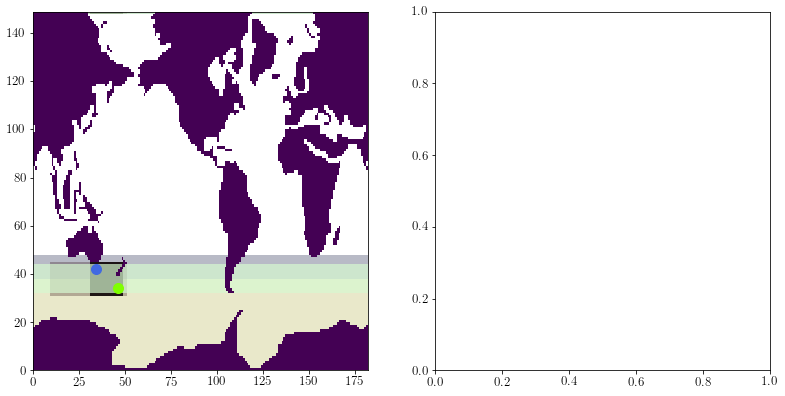

In [6]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['landmask'] = tmesh.tmask[0,0,:,:]# * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
mask = tmesh.landmask.values.astype(float)
mask_land = np.copy(mask)
mask_land[mask_land == 1] = np.nan

mask_so = np.copy(mask)
mask_so[48:148,:] = np.nan
mask_so[mask_so == 0] = np.nan
mask_so1 = np.copy(mask_so)
mask_so1[np.isnan(mask_so1)] = 0
var_copy = tmesh['landmask'].copy()
var_copy.name = 'mask_so'
var_copy.data = mask_so1
tmesh['mask_so'] =var_copy

mask_so50 = np.copy(mask)
mask_so50[38:158,:] = np.nan
mask_so50[mask_so50 == 0] = np.nan
mask_so501 = np.copy(mask_so50)
mask_so501[np.isnan(mask_so501)] = 0
var_copy = tmesh['landmask'].copy()
var_copy.name = 'mask_so50'
var_copy.data = mask_so501
tmesh['mask_so50'] =var_copy

mask_smol = np.copy(mask)
ofs = 3
mask_smol[0:tY_ci-ofs,:] = np.nan
mask_smol[tY_tas+ofs:148,:] = np.nan
mask_smol[:,0:tX_tas-ofs] = np.nan
mask_smol[:,tX_ci+ofs:190] = np.nan
mask_smol[mask_smol == 0] = np.nan
mask_smol1 = np.copy(mask_smol)
mask_smol1[np.isnan(mask_smol1)] = 0
var_copy = tmesh['landmask'].copy()
var_copy.name = 'mask_smol'
var_copy.data = mask_smol1
tmesh['mask_smol'] =var_copy

mask_wide = np.copy(mask)
ofs = 3
mask_wide[0:tY_ci-ofs,:] = np.nan
mask_wide[tY_tas+ofs:148,:] = np.nan
mask_wide[:,0:9] = np.nan
mask_wide[:,51:190] = np.nan
mask_wide[mask_wide == 0] = np.nan
mask_wide1 = np.copy(mask_wide)
mask_wide1[np.isnan(mask_wide1)] = 0
var_copy = tmesh['landmask'].copy()
var_copy.name = 'mask_wide'
var_copy.data = mask_wide1
tmesh['mask_wide'] =var_copy

mask_band = np.copy(mask)
ofs = 2
mask_band[0:tY_ci-ofs,:] = np.nan
mask_band[tY_tas+ofs:148,:] = np.nan
mask_band[mask_band == 0] = np.nan
mask_band1 = np.copy(mask_band)
mask_band1[np.isnan(mask_band1)] = 0
var_copy = tmesh['landmask'].copy()
var_copy.name = 'mask_band'
var_copy.data = mask_band1
tmesh['mask_band'] =var_copy

fact = 1.1
fig, axs = plt.subplots(1,2, figsize=(12*fact, 6*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tcmap = plt.get_cmap("Spectral")
axs[0].pcolormesh(mask_so, cmap = cm.curl, alpha = 0.3 )
axs[0].pcolormesh(mask_so50, cmap = cm.speed, alpha = 0.7 )
axs[0].pcolormesh(mask_smol, cmap = cm.gray, alpha = 0.9 )
axs[0].pcolormesh(mask_wide, cmap = cm.solar, alpha = 0.3 )
axs[0].pcolormesh(mask_band, cmap = cm.algae, alpha = 0.7 )
axs[0].pcolormesh(mask_land, cmap = 'viridis', alpha = 1 )
axs[0].plot(tX_tas, tY_tas, color = 'royalblue', marker = 'o', markersize = 10, label = 'tasmania')
axs[0].plot(tX_ci, tY_ci, color = 'chartreuse', marker = 'o', markersize = 10, label = 'campbell is.')

#tmesh.to_netcdf('./obs/mmask.nc')

## code for extracting raw ts under different meshmasks

In [7]:
ex = False

def extract_ts(tdir,yrst = 1948,yrend = 2019, savenam = True):

    sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data'
    C14d_qtr_c14 = xr.open_dataset(f'./GCBdata/{tdir}_{yrst}_{yrend}_qtrB14b.nc')   ##static
    C14d_Cflx = xr.open_dataset(f'./GCBdata/{tdir}_{yrst}_{yrend}_Cflx.nc') ###static

    times = pd.date_range(f'{yrst}/01/01',f'{yrend}/12/31',freq='MS')

    ### -------- B) get areas/grid variables

    tmeshf = './obs/mmask.nc'
    tmesh = xr.open_dataset(tmeshf)
    masknams = ['mask_so','mask_so50','mask_smol','mask_wide','mask_band']
    for m in range(0,len(masknams)):
        masknam = masknams[m]
        area =  tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:] * tmesh[masknam][:,:]

        qtrnewt_D = C14d_qtr_c14.qtrB14b * area.values* 3.156e7 *2 *1e-14 *6.023e23*1e-26 #some horrible unit conversion taht corrine understands
        cflxnewt_D = C14d_Cflx.Cflx * area.values* 3.156e7*12e-15  #mol/m2/s > pg/yr

        qtrnewt_D['time_counter'] = times
        cflxnewt_D['time_counter'] = times

        qtrflx_mn_D = qtrnewt_D.sum(dim = ['x','y'])
        cflxint_mn_D = cflxnewt_D.sum(dim = ['x','y'])
        
        if savenam:
            qtrflx_mn_D.to_netcdf(f'{sdir}/qtr_{tdir}_{yrst}_{yrend}_{masknam}_ts.nc')
            cflxint_mn_D.to_netcdf(f'{sdir}/cflx_{tdir}_{yrst}_{yrend}_{masknam}_ts.nc')

if ex:
    extract_ts('CEA1',yrst = 1948,yrend = 2019)
    extract_ts('CEC1',yrst = 1948,yrend = 2019)
    extract_ts('CEC2',yrst = 1948,yrend = 2019)
    extract_ts('CEC3',yrst = 1948,yrend = 2019)
    extract_ts('CEC4',yrst = 1948,yrend = 2019)

    extract_ts('CNA1',yrst = 1948,yrend = 2019)
    extract_ts('CNC1',yrst = 1948,yrend = 2019)
    extract_ts('CNC2',yrst = 1948,yrend = 2019)
    extract_ts('CNC3',yrst = 1948,yrend = 2019)
    extract_ts('CNC4',yrst = 1948,yrend = 2019)

## look at non-normalized correlation! not-D is A, C is C

------
mask_so
-★--CEA1-CEC1 (loopyear 1990) r: 0.5572561850566005, 4.6797295213653104e-57
----CEA1-CEC2 (loopyear 1957) r: 0.2876300581577006, 1.700790327052252e-14
-★--CEA1-CEC3 (loopyear 1980) r: 0.5999728850663038, 4.173835250433816e-68
-★--CEA1-CEC4 (loopyear 1967) r: 0.5236970828517737, 1.953279872366782e-49
------
mask_band
-★--CEA1-CEC1 (loopyear 1990) r: 0.5560842785436733, 8.935372252854205e-57
----CEA1-CEC2 (loopyear 1957) r: 0.0086414958538103, 0.8215162063611713
-★--CEA1-CEC3 (loopyear 1980) r: 0.5989361401515311, 8.102245023142526e-68
-★--CEA1-CEC4 (loopyear 1967) r: 0.6208421412661785, 3.8915936620158705e-74


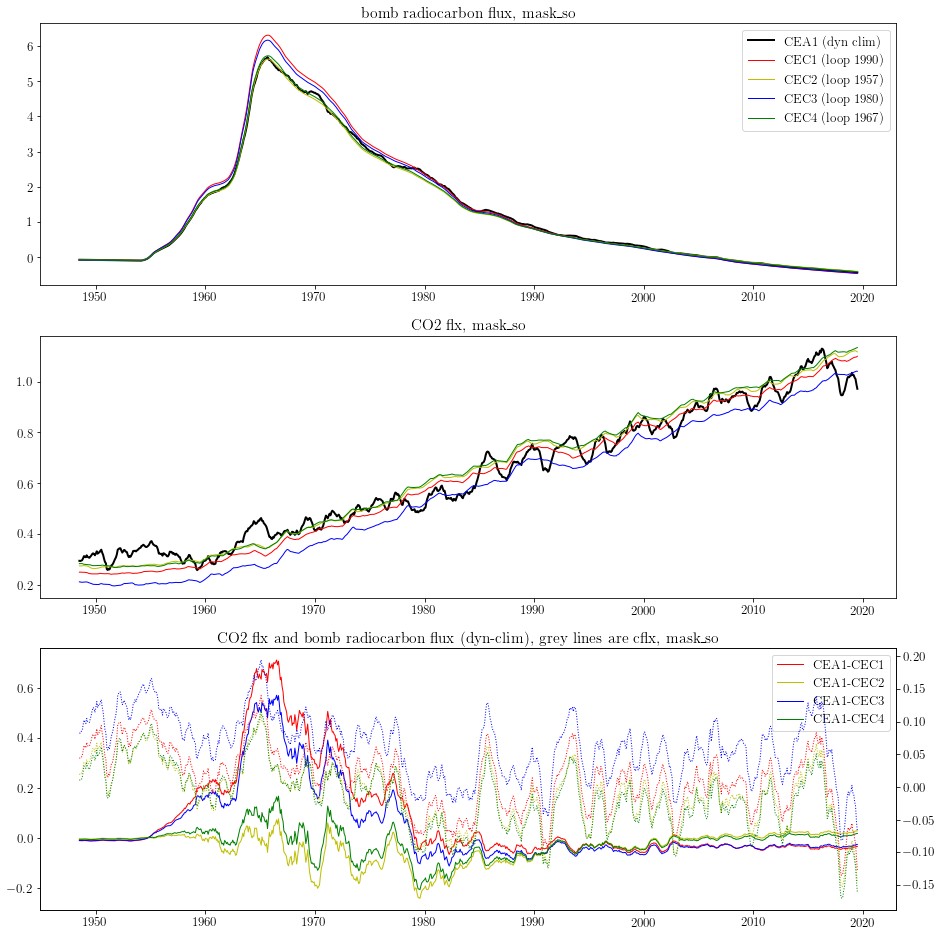

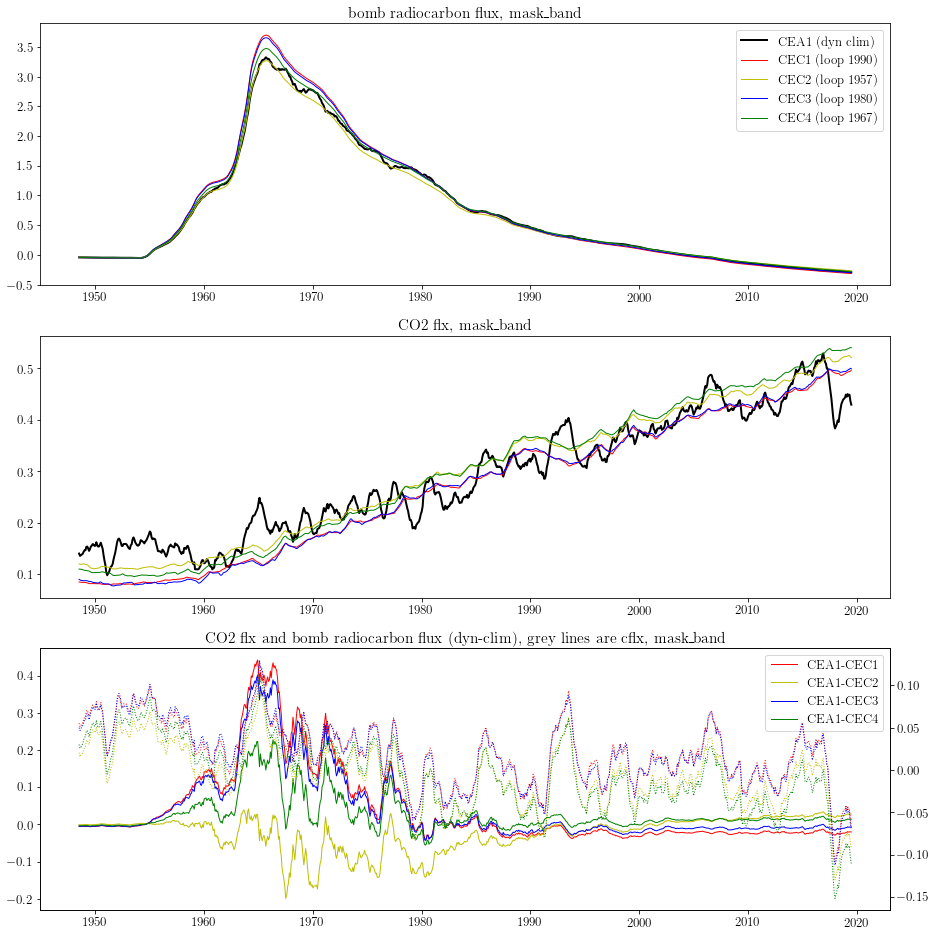

In [8]:
from scipy.stats import pearsonr

yrst = 1948
yrend = 2019
sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data'



masknams = ['mask_so','mask_band'] #'mask_so50','mask_smol','mask_wide',
Adir = 'CEA1'
cols = ['r','y','b','g']
Cdirs = ['CEC1','CEC2','CEC3','CEC4']
yrs = [1990,1957,1980,1967]

ind = 0
for m in range(0,len(masknams)):
    masknam = masknams[m]
    fact = 1.1
    fig, axs = plt.subplots(3,1, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    print('------')
    print(masknam)
    
    qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    cflxA = xr.open_dataset(f'{sdir}/cflx_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    #axs[ind].plot(qtrA.time_counter,qtrA.qtrB14b, color = 'k', label = f'{Adir} (dyn clim)', linewidth = 0.5)
    
    qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
    cflxA_r = cflxA.rolling(time_counter=12, center=True).mean()
    axs[ind].plot(qtrA_r.time_counter,qtrA_r.qtrB14b, color = 'k', label = f'{Adir} (dyn clim)', linewidth = 2)
    axs[ind+1].plot(cflxA_r.time_counter,cflxA_r.Cflx, color = 'k', label = f'{Adir} (dyn clim)', linewidth = 2)
    
    
    for c in range(0,4):
        
        qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdirs[c]}_{yrst}_{yrend}_{masknam}_ts.nc')
        cflxC = xr.open_dataset(f'{sdir}/cflx_{Cdirs[c]}_{yrst}_{yrend}_{masknam}_ts.nc')
        
        qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
        cflxC_r = cflxC.rolling(time_counter=12, center=True).mean()
        #axs[ind].plot(qtrC.time_counter,qtrC.qtrB14b, color = cols[c], linewidth = 0.5)
        axs[ind].plot(qtrC_r.time_counter,qtrC_r.qtrB14b, color = cols[c], label = f'{Cdirs[c]} (loop {yrs[c]})', linewidth = 1)
        
        axs[ind+1].plot(cflxA_r.time_counter,cflxC_r.Cflx, color = cols[c], label = f'{Cdirs[c]} (loop {yrs[c]})', linewidth = 1)
        
        if c == 0:
            axs2b = axs[ind+2].twinx()
        axs2b.plot(cflxA_r.time_counter,cflxA_r.Cflx-cflxC_r.Cflx, color = cols[c], linestyle = ':', label = f'{Adir}-{Cdirs[c]}', linewidth = 1)
        
        axs[ind+2].plot(cflxA_r.time_counter,(qtrA_r.qtrB14b-qtrC_r.qtrB14b)*-1, color = cols[c], label = f'{Adir}-{Cdirs[c]}', linewidth = 1)
        
        ys = 1959
        ye = 2015
        qtrdiff = ((qtrA_r.qtrB14b-qtrC_r.qtrB14b)*-1).sel(time_counter=slice(f'{ys}-01-01', f'{ye}-12-31')).values
        flxdiff = (cflxA_r.Cflx-cflxC_r.Cflx).sel(time_counter=slice(f'{ys}-01-01', f'{ye}-12-31')).values
        flag = '---'
        
        r_value, p_value = pearsonr(qtrdiff, flxdiff)
        if r_value > 0.5:
            flag = '-★-'
        print(f'{flag}-{Adir}-{Cdirs[c]} (loopyear {yrs[c]}) r: {r_value}, {p_value}')      
        
    axs[0].legend()
    axs[2].legend()
    axs[0].set_title(f'bomb radiocarbon flux, {masknam}')
    axs[1].set_title(f'CO2 flx, {masknam}')
    axs[2].set_title(f'CO2 flx and bomb radiocarbon flux (dyn-clim), grey lines are cflx, {masknam}')
    plt.tight_layout()
    plt.savefig(f'./plt/ERA_cflx_qtr_{masknam}.jpg')

------
mask_so
-★--CNA1-CNC1 (loopyear 1990) r: 0.7679589384305008, 4.412992551797604e-134
-★--CNA1-CNC2 (loopyear 1957) r: 0.6203875860089983, 5.3252815133226915e-74
-★--CNA1-CNC3 (loopyear 1980) r: 0.5646596057212018, 7.406436380982367e-59
-★--CNA1-CNC4 (loopyear 1967) r: 0.5671710802263763, 1.7716976561089054e-59
------
mask_so50
-★--CNA1-CNC1 (loopyear 1990) r: 0.6795355068127904, 8.17344461882694e-94
-★--CNA1-CNC2 (loopyear 1957) r: 0.5008616822726524, 1.0204555634184604e-44
----CNA1-CNC3 (loopyear 1980) r: 0.042604845668196514, 0.26582502218479676
----CNA1-CNC4 (loopyear 1967) r: 0.3015395074804328, 7.616232112119307e-16
------
mask_smol
----CNA1-CNC1 (loopyear 1990) r: 0.21460945478164667, 1.4390373315115525e-08
----CNA1-CNC2 (loopyear 1957) r: 0.11743315253244799, 0.002095810186863854
----CNA1-CNC3 (loopyear 1980) r: 0.19968871591125686, 1.393423615913289e-07
----CNA1-CNC4 (loopyear 1967) r: 0.29467733677326086, 3.601167472428717e-15
------
mask_wide
----CNA1-CNC1 (loopyear 199

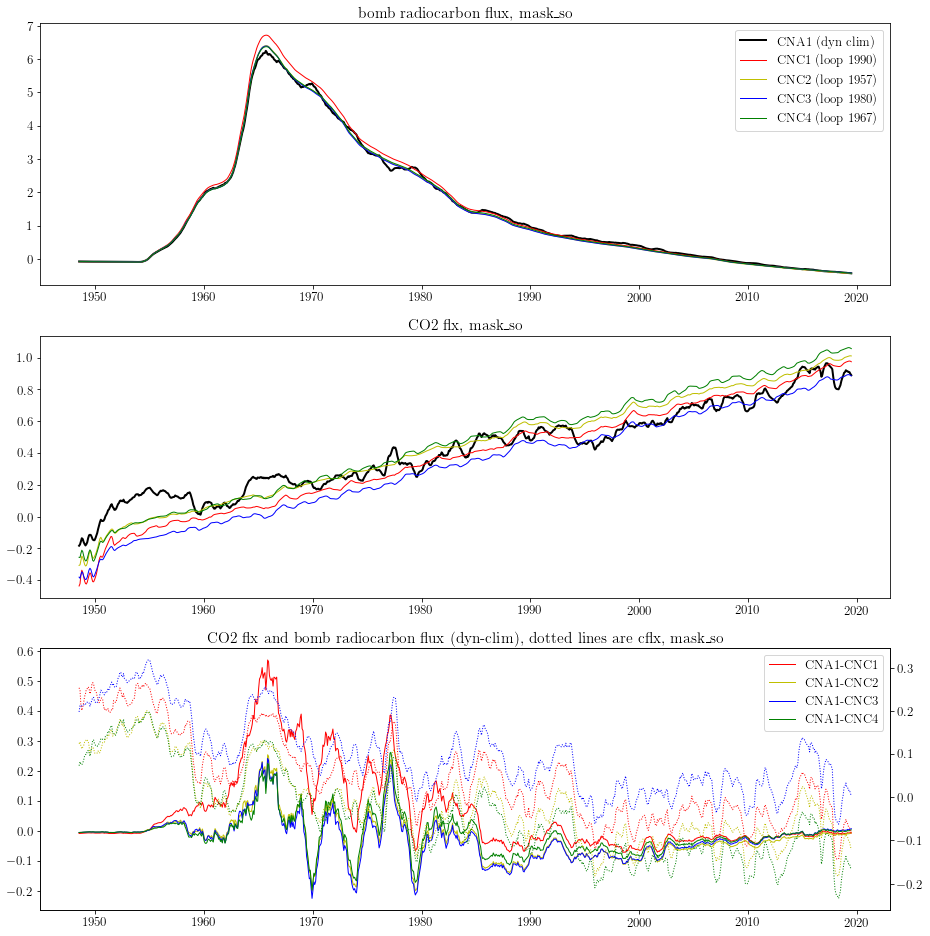

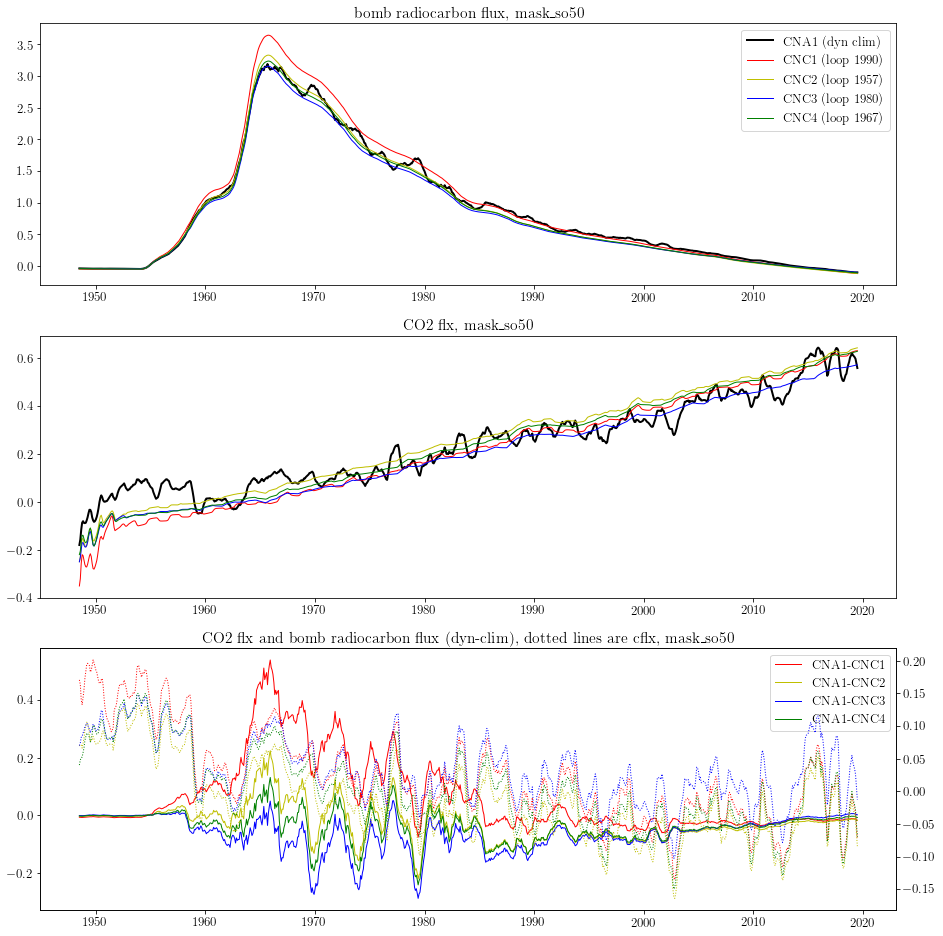

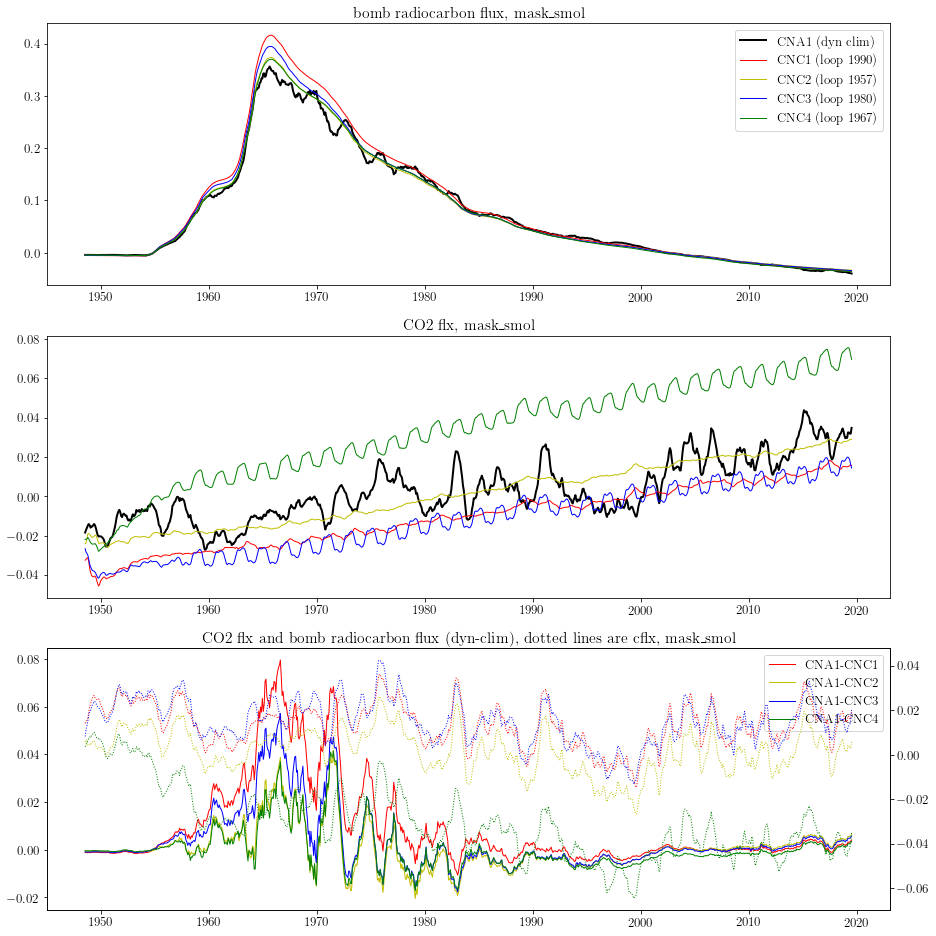

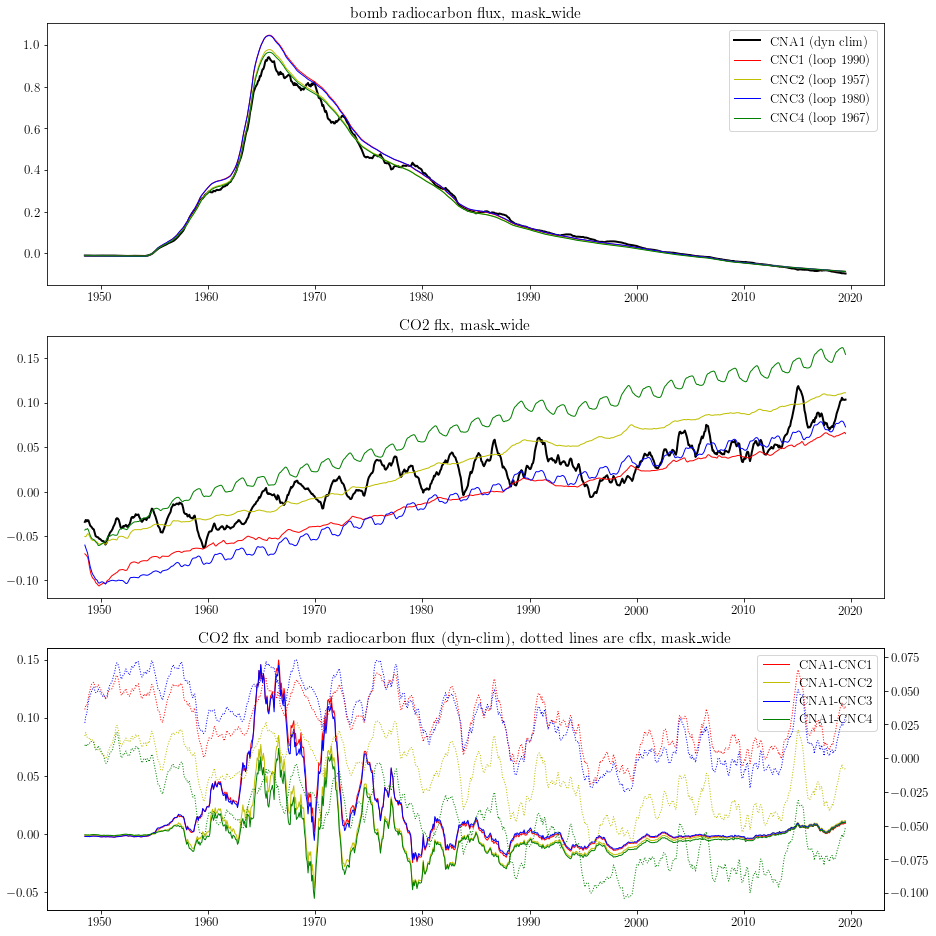

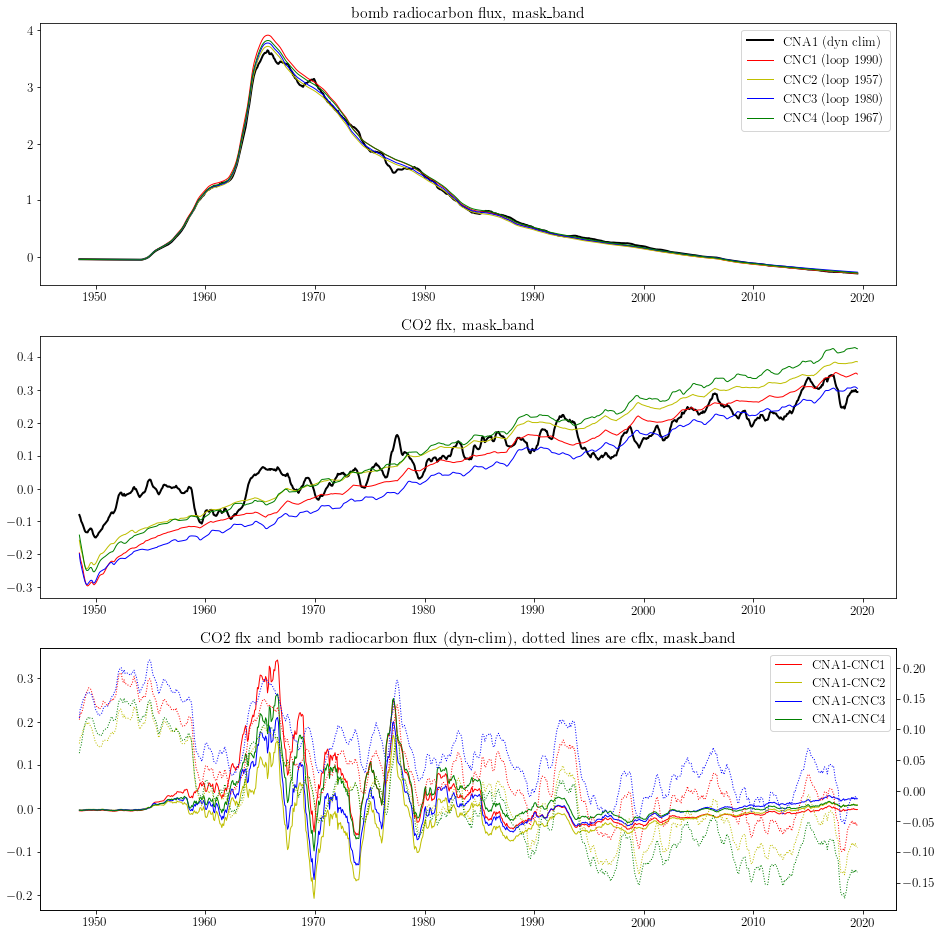

In [9]:
from scipy.stats import pearsonr

yrst = 1948
yrend = 2019
sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data'




masknams = ['mask_so','mask_so50','mask_smol','mask_wide','mask_band']
Adir = 'CNA1'
cols = ['r','y','b','g']
Cdirs = ['CNC1','CNC2','CNC3','CNC4']
yrs = [1990,1957,1980,1967]

ind = 0
for m in range(0,5):#len(masknams)):
    masknam = masknams[m]
    fact = 1.1
    fig, axs = plt.subplots(3,1, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    print('------')
    print(masknam)
    
    qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    cflxA = xr.open_dataset(f'{sdir}/cflx_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    #axs[ind].plot(qtrA.time_counter,qtrA.qtrB14b, color = 'k', label = f'{Adir} (dyn clim)', linewidth = 0.5)
    
    qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
    cflxA_r = cflxA.rolling(time_counter=12, center=True).mean()
    axs[ind].plot(qtrA_r.time_counter,qtrA_r.qtrB14b, color = 'k', label = f'{Adir} (dyn clim)', linewidth = 2)
    axs[ind+1].plot(cflxA_r.time_counter,cflxA_r.Cflx, color = 'k', label = f'{Adir} (dyn clim)', linewidth = 2)
    
    
    for c in range(0,4):
        
        qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdirs[c]}_{yrst}_{yrend}_{masknam}_ts.nc')
        cflxC = xr.open_dataset(f'{sdir}/cflx_{Cdirs[c]}_{yrst}_{yrend}_{masknam}_ts.nc')
        
        qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
        cflxC_r = cflxC.rolling(time_counter=12, center=True).mean()
        #axs[ind].plot(qtrC.time_counter,qtrC.qtrB14b, color = cols[c], linewidth = 0.5)
        axs[ind].plot(qtrC_r.time_counter,qtrC_r.qtrB14b, color = cols[c], label = f'{Cdirs[c]} (loop {yrs[c]})', linewidth = 1)
        
        axs[ind+1].plot(cflxA_r.time_counter,cflxC_r.Cflx, color = cols[c], label = f'{Cdirs[c]} (loop {yrs[c]})', linewidth = 1)
        
        if c == 0:
            axs2b = axs[ind+2].twinx()
        axs2b.plot(cflxA_r.time_counter,cflxA_r.Cflx-cflxC_r.Cflx, color = cols[c], linestyle = ':', label = f'{Adir}-{Cdirs[c]}', linewidth = 1)
        
        axs[ind+2].plot(cflxA_r.time_counter,(qtrA_r.qtrB14b-qtrC_r.qtrB14b)*-1, color = cols[c], label = f'{Adir}-{Cdirs[c]}', linewidth = 1)
        
        ys = 1959
        ye = 2015
        qtrdiff = ((qtrA_r.qtrB14b-qtrC_r.qtrB14b)*-1).sel(time_counter=slice(f'{ys}-01-01', f'{ye}-12-31')).values
        flxdiff = (cflxA_r.Cflx-cflxC_r.Cflx).sel(time_counter=slice(f'{ys}-01-01', f'{ye}-12-31')).values
        flag = '---'
        
        r_value, p_value = pearsonr(qtrdiff, flxdiff)
        if r_value > 0.5:
            flag = '-★-'
        print(f'{flag}-{Adir}-{Cdirs[c]} (loopyear {yrs[c]}) r: {r_value}, {p_value}')      
        
    axs[0].legend()
    axs[2].legend()
    axs[0].set_title(f'bomb radiocarbon flux, {masknam}')
    axs[1].set_title(f'CO2 flx, {masknam}')
    axs[2].set_title(f'CO2 flx and bomb radiocarbon flux (dyn-clim), dotted lines are cflx, {masknam}')
    plt.tight_layout()
    plt.savefig(f'./plt/NCEP_cflx_qtr_{masknam}.jpg')

## get out normalization....

this is now in extract_b14.py and get_depths.py

In [10]:
extract = False

def make_yearlist(yrst, yrend, dtype, tr, baseDir = '/gpfs/data/greenocean/software/runs/'):
    yrs = np.arange(yrst,yrend+1,1)
    ylist = []
    for i in range(0,len(yrs)):
        ty = f'{baseDir}/TOM12_TJ_{tr}/ORCA2_1m_{yrs[i]}*{dtype}*.nc'
        t2 = glob.glob(ty)
        #print(t2)
        ylist.append(t2[0])
    return ylist

def getbts(yrst,yrend, tr, dtype = 'ptrc_T', baseDir = '/gpfs/data/greenocean/software/runs/'):
    print(f'-----{tr} doing-----')
    tdiad = xr.open_mfdataset(make_yearlist(yrst,yrend,'ptrc_T',tr))
    tdiad.B14B.to_netcdf(f'./GCBdata/{tr}_{yrst}_{yrend}_B14B.nc')
    tdiad.C14B.to_netcdf(f'./GCBdata/{tr}_{yrst}_{yrend}_C14B.nc')    
    print(f'{tr} done!')
    
if extract:
    yrst = 1948; yrend = 2019
    
    #getbts(yrst,yrend, 'CEA1', dtype = 'ptrc_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getbts(yrst,yrend, 'CEC1', dtype = 'ptrc_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getbts(yrst,yrend, 'CEC2', dtype = 'ptrc_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getbts(yrst,yrend, 'CEC3', dtype = 'ptrc_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getbts(yrst,yrend, 'CEC4', dtype = 'ptrc_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    
    getbts(yrst,yrend, 'CNA1', dtype = 'ptrc_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getbts(yrst,yrend, 'CNC1', dtype = 'ptrc_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getbts(yrst,yrend, 'CNC2', dtype = 'ptrc_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getbts(yrst,yrend, 'CNC3', dtype = 'ptrc_T', baseDir = '/gpfs/data/greenocean/software/runs/')
    getbts(yrst,yrend, 'CNC4', dtype = 'ptrc_T', baseDir = '/gpfs/data/greenocean/software/runs/')

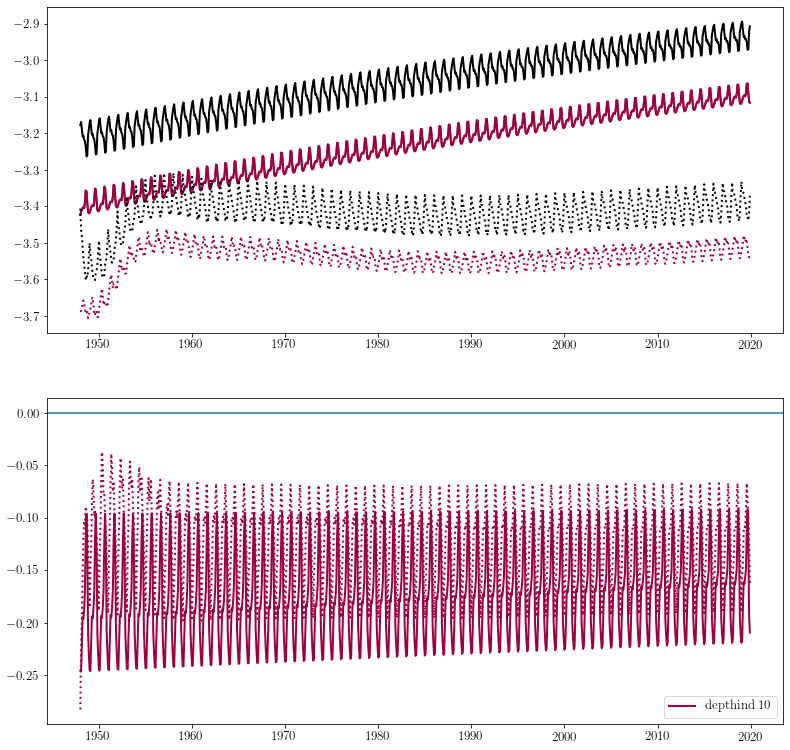

In [16]:
tcm = plt.get_cmap("Spectral")
tdir = '/gpfs/home/mep22dku/scratch/C14/GCBdata/'
masknam = 'mask_smol'


run = 'CEC1'
times = pd.date_range(f"{1948}/01/01",f"{2020}/01/01",freq='MS',closed='left')

fact = 1.1
fig, axs = plt.subplots(2,1, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')

w0 = xr.open_dataset(f'{tdir}{run}_1948_2019_d{0}_B14B_{masknam}.nc')

axs[0].plot(times,w0.B14B, color = 'k', linewidth = 2)

for d in range(10,11):
    
    w1 = xr.open_dataset(f'{tdir}{run}_1948_2019_d{d}_B14B_{masknam}.nc')
    tcolor = tcm(1.*(d-10)/15)
    axs[0].plot(times,w1.B14B, color = tcolor, linewidth = 2)    
    axs[0].plot(times,w1.B14B, color = tcolor, linewidth = 2)    
    
    wd = w1 - w0
    axs[1].plot(times,wd.B14B, color = tcolor, linewidth = 2, label = f'depthind {d}') 
    
axs[1].legend(ncol = 2)

run = 'CNC4'
times = pd.date_range(f"{1948}/01/01",f"{2020}/01/01",freq='MS',closed='left')

w0 = xr.open_dataset(f'{tdir}{run}_1948_2019_d{0}_B14B_{masknam}.nc')

axs[0].plot(times,w0.B14B, color = 'k', linewidth = 2, linestyle = ':')

for d in range(10,11):
    
    w1 = xr.open_dataset(f'{tdir}{run}_1948_2019_d{d}_B14B_{masknam}.nc')
    tcolor = tcm(1.*(d-10)/15)
    axs[0].plot(times,w1.B14B, color = tcolor, linewidth = 2, linestyle = ':')
    
    
    wd = w1 - w0
    axs[1].plot(times,wd.B14B, color = tcolor, linewidth = 2,  linestyle = ':') #label = f'depthind {d}') 
    
axs[1].legend(ncol = 2)
axs[1].axhline(y=0)

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
Cdir = 'CEC4'
masknam = 'mask_band'
for d in range(10,25):
    tcolor = tcm(1.*(d-10)/15)
    w0 = xr.open_dataset(f'{tdir}/{Cdir}_1948_2019_d{0}_B14B_{masknam}.nc')
    w1 = xr.open_dataset(f'{tdir}/{Cdir}_1948_2019_d{d}_B14B_{masknam}.nc')
    wd = w0 - w1
    times = pd.date_range(f"{1948}/01/01",f"{2020}/01/01",freq='MS',closed='left')
    
    wd_r = wd.rolling(time_counter=12, center=True).mean()
    wd_r['time_counter'] = times#.sel(time_counter=slice(f'{1948}-01-01', f'{1948}-12-31'))
    axs[0].plot(wd_r.time_counter, wd_r.C14B, color = tcolor)
    axs[0].axhline(y=0)
    #times = pd.date_range(f"{1948}/01/01",f"{1948}/01/01",freq='MS',closed='left')
    #
    
    #axs[0].plot(times,wd_r.C14B, color = tcolor, linewidth = 2)   

## ok do the same analysis, normalized

    Therefore to be able to use 14C to infer changes in CO2, we need first to correct for the
    changing vertical gradient of 14C. This can be done easily by normalising the 14C fluxes to the
    vertical gradient, so that 14C-normalised = 14C/dc14dz*1 (with 1 being an arbitrary relative
    dc14dz ratio, e.g. that of year 2010).

In [ ]:
def get_normsig(rnam, d, yrst = 1948, yrend = 2019, normy = 1990):

    C_run = xr.open_mfdataset(make_yearlist(yrst,yrend,rnam,d))
    times = pd.date_range(f"{yrst}/01/01",f"{yrend}/12/31",freq='MS')
    C_run['time_counter'] = times
    tl = (len(times))
    print(tl)
    DC14DZ = np.squeeze(C_run.DC14DZ.values); DC14DZ[np.where(DC14DZ == 0)] = np.nan

    norm = np.squeeze(C_run.DC14DZ.sel(time_counter=slice(f'{normy}-01-01', f'{normy}-12-31')).values)
    repeats = tl // 12
    normt = np.tile(norm, repeats)
    normsig = normt/DC14DZ
    normsig[normsig > 10 ] = np.nan
    normsig[normsig < -10 ] = np.nan
    #C_run = xr.open_mfdataset(make_yearlist(1948,2019,'CEA1',5))
    C_run = C_run.assign(normsig=C_run['DDICDZ'])

    # Replace the data of the new variable "pressure"
    C_run['normsig'].data = normsig
    
    C_run.to_netcdf(f'./GCBdata/{rnam}_d{d}norm_y{normy}.nc')
    
    return C_run

In [ ]:
verb = True

Adir = 'CNA1';
columns = ['CNC1','CNC2','CNC3','CNC4']
Cdirs = columns
rows = np.array([0,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
df = pd.DataFrame(columns=columns, index=rows)

yrs = [1990,1957,1980,1967]
ys = 1948; ye = 2019; #ts
ysp = 1959; yep = 2015 #where we are taking normalization from

masknam = 'mask_so'
masknams = ['mask_so','mask_so50','mask_smol','mask_wide','mask_band']



for m in range(0,5):#len(masknams)):

    masknam = masknams[m]
    print(masknam)
    df = pd.DataFrame(columns=columns, index=rows)
    
    for c in range(0,4):

        Cdir = Cdirs[c]

        qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
        cflxA = xr.open_dataset(f'{sdir}/cflx_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
        qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
        cflxC = xr.open_dataset(f'{sdir}/cflx_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')

        qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
        cflxA_r = cflxA.rolling(time_counter=12, center=True).mean()
        qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
        cflxC_r = cflxC.rolling(time_counter=12, center=True).mean()

        times = pd.date_range(f'{ys}/01/01',f'{ye}/12/31',freq='MS')


        qtrdiff = ((qtrA_r.qtrB14b-qtrC_r.qtrB14b)*-1).sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
        flxdiff = (cflxA_r.Cflx-cflxC_r.Cflx).sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
        flag = '---'
        r_value, p_value = pearsonr(qtrdiff, flxdiff)
        if r_value > 0.5:
            flag = '-★-'
        if verb:
            print(f'{flag}-{Adir}-{Cdir} (loopyr {yrs[c]} (not normalized) ({ysp}-{yep}) r: {r_value}, {p_value}')      
        df.loc[0, Cdir] = r_value
        
        for d in range(10,25):
            w0 = xr.open_dataset(f'{tdir}{Cdir}_1948_2019_d{0}_B14B_{masknam}.nc')
            w1 = xr.open_dataset(f'{tdir}{Cdir}_1948_2019_d{d}_B14B_{masknam}.nc')
            wd = w0 - w1
            wd['time_counter'] = times
            wd_r = wd.rolling(time_counter=12, center=True).mean().sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
            norm = (qtrdiff/np.abs(wd_r.B14B))
            r_value, p_value = pearsonr(norm, flxdiff)
            flag = '---'
            if r_value > 0.5:
                flag = '-★-'
            if verb:
                print(f'{flag}-{Adir}-{Cdir} (dpthl {d}) ({ysp}-{yep})------------------- r: {r_value}, {p_value}')    
            df.loc[d, Cdir] = r_value
        print('-------------')
        #df.to_csv(f'./GCBdata/{Adir}_corr_{masknam}_{ysp}-{yep}.csv')


In [ ]:

Adir = 'CEA1';
columns = ['CEC1','CEC2','CEC3','CEC4']
Cdirs = columns
rows = np.array([0,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
yrst = 1948; yrend = 2019; #ts
ysp = 1959; yep = 2015 #where we are taking normalization from

masknam = 'mask_so'
masknams = ['mask_so','mask_so50','mask_smol','mask_wide','mask_band']


for m in range(0,5):#len(masknams)):

    masknam = masknams[m]
    print(masknam)
    df = pd.DataFrame(columns=columns, index=rows)
    
    for c in range(0,4):

        Cdir = Cdirs[c]

        qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
        cflxA = xr.open_dataset(f'{sdir}/cflx_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
        qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
        cflxC = xr.open_dataset(f'{sdir}/cflx_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')

        qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
        cflxA_r = cflxA.rolling(time_counter=12, center=True).mean()
        qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
        cflxC_r = cflxC.rolling(time_counter=12, center=True).mean()

        times = pd.date_range(f'{ys}/01/01',f'{ye}/12/31',freq='MS')


        qtrdiff = ((qtrA_r.qtrB14b-qtrC_r.qtrB14b)*-1).sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
        flxdiff = (cflxA_r.Cflx-cflxC_r.Cflx).sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
        flag = '---'
        r_value, p_value = pearsonr(qtrdiff, flxdiff)
        if r_value > 0.5:
            flag = '-★-'
        print(f'{flag}-{Adir}-{Cdir} (loopyr {yrs[c]} (not normalized) ({ysp}-{yep}) r: {r_value}, {p_value}')      
        df.loc[0, Cdir] = r_value
        
        for d in range(10,25):
            w0 = xr.open_dataset(f'{tdir}{Cdir}_1948_2019_d{0}_C14B_{masknam}.nc')
            w1 = xr.open_dataset(f'{tdir}{Cdir}_1948_2019_d{d}_C14B_{masknam}.nc')
            wd = w0 - w1
            wd['time_counter'] = times
            wd_r = wd.rolling(time_counter=12, center=True).mean().sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
            
            ## deal with crossing the zero
            if (np.nanmin(wd_r.C14B) < 0):
                print('crossed the 0!')
                wdn = wd_r - 2*np.nanmin(wd_r.C14B)
                wdn = wdn.C14B.values
                norm = qtrdiff.values/wdn

            else:
                wdn = wd_r.C14B.values
                norm = (qtrdiff.values/(wdn))            
            
            r_value, p_value = pearsonr(norm, flxdiff)
            if r_value > 0.5:
                flag = '-★-'
            print(f'{flag}-{Adir}-{Cdir} (dpthl {d}) ({ysp}-{yep})------------------- r: {r_value}, {p_value}')    
            df.loc[d, Cdir] = r_value
        df.to_csv(f'./GCBdata/{Adir}_corr_{masknam}_{ysp}-{yep}.csv')


In [ ]:
sh = True
if sh:
    Adir = 'CNA1';
    columns = ['CNC1','CNC2','CNC3','CNC4']
    Cdirs = columns
    rows = np.array([0,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
    df = pd.DataFrame(columns=columns, index=rows)

    yrs = [1990,1957,1980,1967]
    ys = 1948; ye = 2019; #ts
    ysp = 1959; yep = 2015 #where we are taking normalization from

    masknam = 'mask_so'
    masknams = ['mask_so','mask_band','mask_so50','mask_smol','mask_wide']

    for m in range(0,5):#len(masknams)):

        masknam = masknams[m]
        print(masknam)
        df = pd.DataFrame(columns=columns, index=rows)

        for c in range(0,4):

            Cdir = Cdirs[c]

            qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
            cflxA = xr.open_dataset(f'{sdir}/cflx_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
            qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
            cflxC = xr.open_dataset(f'{sdir}/cflx_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')

            qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
            cflxA_r = cflxA.rolling(time_counter=12, center=True).mean()
            qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
            cflxC_r = cflxC.rolling(time_counter=12, center=True).mean()

            times = pd.date_range(f'{ys}/01/01',f'{ye}/12/31',freq='MS')


            qtrdiff = ((qtrA_r.qtrB14b-qtrC_r.qtrB14b)*-1).sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
            flxdiff = (cflxA_r.Cflx-cflxC_r.Cflx).sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
            flag = '---'
            r_value, p_value = pearsonr(qtrdiff, flxdiff)
            if r_value > 0.5:
                flag = '-★-'
            print(f'{flag}-{Adir}-{Cdir} (loopyr {yrs[c]} (not normalized) ({ysp}-{yep}) r: {r_value}, {p_value}')      
            df.loc[0, Cdir] = r_value

            for d in range(10,25):
                w0 = xr.open_dataset(f'{tdir}{Cdir}_1948_2019_d{0}_C14B_{masknam}.nc')
                w1 = xr.open_dataset(f'{tdir}{Cdir}_1948_2019_d{d}_C14B_{masknam}.nc')
                wd = w0 - w1
                wd['time_counter'] = times
                wd_r = wd.rolling(time_counter=12, center=True).mean().sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))

                ## deal with crossing the zero
                if (np.nanmin(wd_r.C14B) < 0):
                    print('crossed the 0!')
                    wdn = wd_r - 2*np.nanmin(wd_r.C14B)
                    wdn = wdn.C14B.values
                    norm = qtrdiff.values/wdn

                else:
                    wdn = wd_r.C14B.values
                    norm = (qtrdiff.values/(wdn))            

                r_value, p_value = pearsonr(norm, flxdiff)
                if r_value > 0.5:
                    flag = '-★-'
                print(f'{flag}-{Adir}-{Cdir} (dpthl {d}) ({ysp}-{yep})------------------- r: {r_value}, {p_value}')    
                df.loc[d, Cdir] = r_value
            df.to_csv(f'./GCBdata/{Adir}_corr_{masknam}_{ysp}-{yep}.csv')


## make a plot of all the correlations

In [ ]:
ysp = 1959; yep= 2015
fig, axs = plt.subplots(2,3, figsize=(12*fact, 12*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tcmap = plt.get_cmap("Spectral")
axs[0].pcolormesh(mask_so, cmap = cm.curl, alpha = 0.3 )
axs[0].pcolormesh(mask_so50, cmap = cm.speed, alpha = 0.7 )
axs[0].pcolormesh(mask_smol, cmap = cm.gray, alpha = 0.9 )
axs[0].pcolormesh(mask_wide, cmap = cm.solar, alpha = 0.3 )
axs[0].pcolormesh(mask_band, cmap = cm.algae, alpha = 0.7 )
axs[0].pcolormesh(mask_land, cmap = 'viridis', alpha = 1 )
axs[0].plot(tX_tas, tY_tas, color = 'royalblue', marker = 'o', markersize = 10, label = 'tasmania')
axs[0].plot(tX_ci, tY_ci, color = 'chartreuse', marker = 'o', markersize = 10, label = 'campbell is.')


for ind in range(1,6):
    masknams = ['mask_so','mask_so50','mask_smol','mask_wide','mask_band']
    masknam = masknams[ind-1]
    rows = np.array([0,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])
    cols = ['r','y','b','g']
    
    Cdirs = ['CEC1','CEC2','CEC3','CEC4']
    corr_so = pd.read_csv(f'./GCBdata/CEA1_corr_{masknam}_{ysp}-{yep}.csv', index_col = False)
    corr_so.index = rows
    yrs = [1990,1957,1980,1967]
    for i in range(0,4):

        for r in range(0,16):
            rv = rows[r]
            if r == 0:
                axs[ind].plot(corr_so.loc[rv,Cdirs[i]],-rv,marker = 'o', color = cols[i], label = f'{Cdirs[i]} (loop {yrs[i]}')
            else:
                axs[ind].plot(corr_so.loc[rv,Cdirs[i]],-rv,marker = 'o', color = cols[i])
            
    Cdirs = ['CNC1','CNC2','CNC3','CNC4']
    corr_so = pd.read_csv(f'./GCBdata/CNA1_corr_{masknam}_{ysp}-{yep}.csv', index_col = False)
    corr_so.index = rows
    yrs = [1990,1957,1980,1967]
    for i in range(0,4):

        for r in range(0,16):
            rv = rows[r]
            if r == 0:
                axs[ind].plot(corr_so.loc[rv,Cdirs[i]],-rv,marker = 'x', color = cols[i], label = f'{Cdirs[i]} (loop {yrs[i]}')
            else:
                axs[ind].plot(corr_so.loc[rv,Cdirs[i]],-rv,marker = 'x', color = cols[i])            
            
            
            
    axs[ind].set_xlim([0,0.9])
    axs[ind].axvline(x=0.5)
    axs[ind].grid(alpha = 0.5)
    axs[1].legend(loc = 'lower left')
    axs[ind].set_title(masknam)
    
plt.suptitle('pearson R between [C14flx[Adir-Cdir]] and [CO2flux[Adir-Cdir]] for different masks, loop years, and depths \n 1959-2015. circles are ERA, x are NCEP')

## but why doesn't the normalization matter, i feel like it should

In [ ]:

def make_plot(Adir,Cdir,masknam,yrst,yrend,ysp,yep,loop,d, ttit):
    
    sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data/'
    qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    cflxA = xr.open_dataset(f'{sdir}/cflx_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
    cflxC = xr.open_dataset(f'{sdir}/cflx_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')

    qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
    cflxA_r = cflxA.rolling(time_counter=12, center=True).mean()
    qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
    cflxC_r = cflxC.rolling(time_counter=12, center=True).mean()

    times = pd.date_range(f'{ys}/01/01',f'{ye}/12/31',freq='MS')

    qtrdiff = ((qtrA_r.qtrB14b-qtrC_r.qtrB14b)*-1).sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
    flxdiff = (cflxA_r.Cflx-cflxC_r.Cflx).sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
    tdir = '/gpfs/home/mep22dku/scratch/C14/GCBdata/'
    w0 = xr.open_dataset(f'{tdir}/{Cdir}_1948_2019_d{0}_C14B_{masknam}.nc')
    w1 = xr.open_dataset(f'{tdir}/{Cdir}_1948_2019_d{d}_C14B_{masknam}.nc')
    wd = w0 - w1
    wd['time_counter'] = times
    wd_r = wd.rolling(time_counter=12, center=True).mean().sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
    
    if (np.nanmin(wd_r.C14B) < 0):
        wdn = wd_r - 2*np.nanmin(wd_r.C14B)
        wdn = wdn.C14B.values
        norm = qtrdiff.values/wdn

    else:
        wdn = wd_r.C14B
        wdn = wdn
        norm = (qtrdiff.values/(wdn))

    ### ----

    fig, axs = plt.subplots(2,2, figsize=(12*fact, 10*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs0b = axs[0].twinx()
    axs0b.plot(qtrdiff.time_counter,flxdiff, color = 'k')
    axs0b.set_ylabel('Co2 flux A-C')
    axs[0].plot(qtrdiff.time_counter,qtrdiff, color = 'chartreuse')
    axs[0].set_ylabel('c14 flux A-C (green)')
    axs0b.grid()

    axs0b = axs[1].twinx()
    axs0b.plot(qtrdiff.time_counter,flxdiff, color = 'k')
    axs[1].plot(qtrdiff.time_counter,norm, color = 'royalblue')
    axs0b.set_ylabel('Co2 flux A-C')
    axs[1].set_ylabel('c14 flux A-C, normalized to gradient (blue)')
    axs0b.grid()

    axs0b = axs[2].twinx()
    axs[2].plot(qtrdiff.time_counter,qtrdiff/np.max(qtrdiff), color = 'chartreuse')
    axs[2].plot(qtrdiff.time_counter,norm/np.max(norm), color = 'royalblue')
    axs0b.plot(wd_r.time_counter,wdn, color = 'r')
    axs[2].set_ylabel('c14 flux A-C/ max of timeseries \n (so that the 2 can be compared)')
    axs0b.set_ylabel(f'depth gradient, c14surface - {d}')
    axs0b.grid()


    axs[3].scatter(flxdiff,qtrdiff/np.max(qtrdiff), color = 'chartreuse')
    axs[3].scatter(flxdiff,norm/np.max(norm), color = 'royalblue')
    axs[3].grid()
    r_value, p_value = pearsonr(qtrdiff/np.max(qtrdiff), flxdiff)
    r_valuen, p_value = pearsonr(norm/np.max(norm), flxdiff)
    print(f'{Adir}/{Cdir}, loopyr {loop} norm to {d}, raw r: {r_value} norm r: {r_valuen}')
    
    axs[0].set_title('ts of co2 flux (A-C), black, \n and c14 flux (A-C), green')
    axs[1].set_title('ts of co2 flux (A-C), black, \n and c14 flux (A-C) normalized to depth gradient, blue')
    axs[2].set_title('ts of c14 flux (A-C), raw (green) and normalized (blue) \n (div. by max of ts) and c14 gradient (red)')
    axs[3].set_title(f'c14flx (normalized to max of ts) vs co2, norm (blue) + raw (green) \n raw r: {r_value} norm r: {r_valuen}')
    plt.suptitle(ttit)
    plt.tight_layout()
    fig.savefig(f'./plt/corrplot{Adir}-{Cdir}-{ysp}-{yep}_{masknam}_d{d}.jpg')



In [ ]:
yrst = 1948; yrend = 2019
ysp = 1959; yep = 2015

masknam = 'mask_so'
Adir = 'CNA1'
Cdir = 'CNC1'; loop = 1990
d = 19; forc = 'NCEP'
ttit = f'correlation between c14flx and co2flx, {masknam} {ysp}-{yep} \n {Adir}-{Cdir} ({forc}, looping over {loop}), norm to depth lev {d}'
make_plot(Adir,Cdir,masknam,yrst,yrend,ysp,yep,loop,d, ttit)

Adir = 'CEA1'
Cdir = 'CEC3'; loop = 1980
d = 24; forc = 'ERA'
ttit = f'correlation between c14flx and co2flx, {masknam} {ysp}-{yep} \n {Adir}-{Cdir} ({forc}, looping over {loop}), norm to depth lev {d}'
make_plot(Adir,Cdir,masknam,yrst,yrend,ysp,yep,loop,d, ttit)

masknam = 'mask_band'
Adir = 'CNA1'
Cdir = 'CNC1'; loop = 1990
d = 13; forc = 'NCEP'
ttit = f'correlation between c14flx and co2flx, {masknam} {ysp}-{yep} \n {Adir}-{Cdir} ({forc}, looping over {loop}), norm to depth lev {d}'
make_plot(Adir,Cdir,masknam,yrst,yrend,ysp,yep,loop,d, ttit)

Adir = 'CEA1'
Cdir = 'CEC4'; loop = 1967
d = 24; forc = 'ERA'
ttit = f'correlation between c14flx and co2flx, {masknam} {ysp}-{yep} \n {Adir}-{Cdir} ({forc}, looping over {loop}), norm to depth lev {d}'
make_plot(Adir,Cdir,masknam,yrst,yrend,ysp,yep,loop,d, ttit)

In [ ]:
Adir = 'CEA1'
Cdir = 'CEC4'; loop = 1967
d = 13; forc = 'ERA'
ttit = f'correlation between c14flx and co2flx, {masknam} {ysp}-{yep} \n {Adir}-{Cdir} ({forc}, looping over {loop}), norm to depth lev {d}'
make_plot(Adir,Cdir,masknam,yrst,yrend,ysp,yep,loop,d, ttit)

In [ ]:
masknam = 'mask_so'
Adir = 'CNA1'
Cdir = 'CNC4'; loop = 1967
d = 10; forc = 'NCEP'
ttit = f'correlation between c14flx and co2flx, {masknam} {ysp}-{yep} \n {Adir}-{Cdir} ({forc}, looping over {loop}), norm to depth lev {d}'
make_plot(Adir,Cdir,masknam,yrst,yrend,ysp,yep,loop,d, ttit)

## add observational data to best correlations

In [ ]:
# Specify the path to your Excel file
file_path = './obs/Campbell_Is_vs_Tasmania_gradient_data_Corinne.xlsx'

# Read the Excel file, skipping the first row
df = pd.read_excel(file_path, skiprows=1)

df.rename(columns={'Year (centred on year of growth e.g. 1952 represents October 1951 to March 1952)': 'yr'}, inplace=True)
df.rename(columns={'Delta14C difference': 'Dc14diff'}, inplace=True)
# print(df.columns)

# print(df.yr)

times = pd.date_range(f'{1950}/01/01',f'{2013}/01/01',freq='Y')
# print(times)

start_year = 1950
num_years = 64

# Create the date range
date_range = pd.date_range(start=f'{start_year}-07-01', periods=num_years, freq='AS-JUL')
plt.plot(date_range,df.Dc14diff/np.max(df.Dc14diff), 'yo')

In [ ]:

def make_obs_plot(Adir,Cdir,masknam,yrst,yrend,ysp,yep,loop,d, ttit):
    
    sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data/'
    qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    cflxA = xr.open_dataset(f'{sdir}/cflx_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
    qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
    cflxC = xr.open_dataset(f'{sdir}/cflx_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')

    qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
    cflxA_r = cflxA.rolling(time_counter=12, center=True).mean()
    qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
    cflxC_r = cflxC.rolling(time_counter=12, center=True).mean()

    times = pd.date_range(f'{ys}/01/01',f'{ye}/12/31',freq='MS')

    qtrdiff = ((qtrA_r.qtrB14b-qtrC_r.qtrB14b)*-1).sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
    flxdiff = (cflxA_r.Cflx-cflxC_r.Cflx).sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
    tdir = '/gpfs/home/mep22dku/scratch/C14/GCBdata/'
    w0 = xr.open_dataset(f'{tdir}/{Cdir}_1948_2019_d{0}_C14B_{masknam}.nc')
    w1 = xr.open_dataset(f'{tdir}/{Cdir}_1948_2019_d{d}_C14B_{masknam}.nc')
    wd = w0 - w1
    wd['time_counter'] = times
    wd_r = wd.rolling(time_counter=12, center=True).mean().sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
    
    if (np.nanmin(wd_r.C14B) < 0):
        wdn = wd_r - 2*np.nanmin(wd_r.C14B)
        wdn = wdn.C14B.values
        norm = qtrdiff.values/wdn

    else:
        wdn = wd_r.C14B
        wdn = wdn
        norm = (qtrdiff.values/(wdn))

    ### ----

    fig, axs = plt.subplots(2,1, figsize=(12*fact, 10*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs0b = axs[0].twinx()
    axs0b.plot(qtrdiff.time_counter,flxdiff, color = 'k')
    axs0b.set_ylabel('Co2 flux A-C')
    axs[0].plot(qtrdiff.time_counter,qtrdiff/np.max(qtrdiff), color = 'chartreuse')
    axs[0].set_ylabel('c14 flux A-C (green)')
    axs0b.grid()

    axs0b = axs[1].twinx()
    axs0b.plot(qtrdiff.time_counter,flxdiff, color = 'k')
    axs[1].plot(qtrdiff.time_counter,norm/np.max(norm), color = 'royalblue')
    axs0b.set_ylabel('Co2 flux A-C')
    axs[1].set_ylabel('c14 flux A-C, normalized to gradient (blue)')
    axs0b.grid()

    axs[0].plot(date_range,df.Dc14diff/np.min(df.Dc14diff), 'yo-')
    axs[1].plot(date_range,df.Dc14diff/np.min(df.Dc14diff), 'yo-')
#     axs0b = axs[2].twinx()
#     axs[2].plot(qtrdiff.time_counter,qtrdiff/np.max(qtrdiff), color = 'chartreuse')
#     axs[2].plot(qtrdiff.time_counter,norm/np.max(norm), color = 'royalblue')
#     axs0b.plot(wd_r.time_counter,wdn, color = 'r')
#     axs[2].set_ylabel('c14 flux A-C/ max of timeseries \n (so that the 2 can be compared)')
#     axs0b.set_ylabel(f'depth gradient, c14surface - {d}')
#     axs0b.grid()


#     axs[3].scatter(flxdiff,qtrdiff/np.max(qtrdiff), color = 'chartreuse')
#     axs[3].scatter(flxdiff,norm/np.max(norm), color = 'royalblue')
#     axs[3].grid()
    r_value, p_value = pearsonr(qtrdiff/np.max(qtrdiff), flxdiff)
    r_valuen, p_value = pearsonr(norm/np.max(norm), flxdiff)
#     print(f'{Adir}/{Cdir}, loopyr {loop} norm to {d}, raw r: {r_value} norm r: {r_valuen}')
    
    axs[0].set_title('ts of co2 flux (A-C), black, \n and c14 flux (A-C), green')
    axs[1].set_title(f'ts of co2 flux (A-C), black, \n and c14 flux (A-C) normalized to depth gradient, blue \n raw r {r_value}, normalized r {r_valuen}')
    # axs[2].set_title('ts of c14 flux (A-C), raw (green) and normalized (blue) \n (div. by max of ts) and c14 gradient (red)')
    # axs[3].set_title(f'c14flx (normalized to max of ts) vs co2, norm (blue) + raw (green) \n raw r: {r_value} norm r: {r_valuen}')
    plt.suptitle(ttit)
    plt.tight_layout()
    fig.savefig(f'./plt/obs_corrplot{Adir}-{Cdir}-{ysp}-{yep}_{masknam}_d{d}.jpg')



In [ ]:
yrst = 1948; yrend = 2019
ysp = 1959; yep = 2015

# masknam = 'mask_so'
# Adir = 'CNA1'
# Cdir = 'CNC1'; loop = 1990
# d = 19; forc = 'NCEP'
# ttit = f'correlation between c14flx and co2flx, {masknam} {ysp}-{yep} \n {Adir}-{Cdir} ({forc}, looping over {loop}), norm to depth lev {d}'
# make_obs_plot(Adir,Cdir,masknam,yrst,yrend,ysp,yep,loop,d, ttit)

# Adir = 'CEA1'
# Cdir = 'CEC3'; loop = 1980
# d = 24; forc = 'ERA'
# ttit = f'correlation between c14flx and co2flx, {masknam} {ysp}-{yep} \n {Adir}-{Cdir} ({forc}, looping over {loop}), norm to depth lev {d}'
# make_obs_plot(Adir,Cdir,masknam,yrst,yrend,ysp,yep,loop,d, ttit)

masknam = 'mask_band'
Adir = 'CNA1'
Cdir = 'CNC1'; loop = 1990
d = 13; forc = 'NCEP'
ttit = f'correlation between c14flx and co2flx, {masknam} {ysp}-{yep} \n {Adir}-{Cdir} ({forc}, looping over {loop}), norm to depth lev {d} (obs in yellow)'
make_obs_plot(Adir,Cdir,masknam,yrst,yrend,ysp,yep,loop,d, ttit)

Adir = 'CEA1'
Cdir = 'CEC4'; loop = 1967
d = 24; forc = 'ERA'
ttit = f'correlation between c14flx and co2flx, {masknam} {ysp}-{yep} \n {Adir}-{Cdir} ({forc}, looping over {loop}), norm to depth lev {d} (obs in yellow)'
make_obs_plot(Adir,Cdir,masknam,yrst,yrend,ysp,yep,loop,d, ttit)

In [ ]:

masknam = 'mask_wide'
Adir = 'CNA1'
Cdir = 'CNC3'; loop = 1980
d = 10; forc = 'NCEP'
ttit = f'correlation between c14flx and co2flx, {masknam} {ysp}-{yep} \n {Adir}-{Cdir} ({forc}, looping over {loop}), norm to depth lev {d} (obs in yellow)'
make_obs_plot(Adir,Cdir,masknam,yrst,yrend,ysp,yep,loop,d, ttit)

Adir = 'CEA1'
Cdir = 'CEC3'; loop = 1980
d = 20; forc = 'ERA'
ttit = f'correlation between c14flx and co2flx, {masknam} {ysp}-{yep} \n {Adir}-{Cdir} ({forc}, looping over {loop}), norm to depth lev {d} (obs in yellow)'
make_obs_plot(Adir,Cdir,masknam,yrst,yrend,ysp,yep,loop,d, ttit)

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(12*fact, 6*fact), facecolor='w', edgecolor='k')


masknam = 'mask_wide'

sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data/'
axs.plot(date_range,df.Dc14diff/np.min(df.Dc14diff), 'yo-')


times = pd.date_range(f'{ys}/01/01',f'{ye}/12/31',freq='MS')


Adir = 'CEA1'; Cdir = 'CEC1'
qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
qtrdiff = ((qtrA_r.qtrB14b-qtrC_r.qtrB14b)*-1)#.sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
axs.plot(times,qtrdiff/np.max(qtrdiff), 'r-', label = 'era-forced A-C')

Adir = 'CNA1'; Cdir = 'CNC1'
qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
qtrdiff = ((qtrA_r.qtrB14b-qtrC_r.qtrB14b)*-1)#.sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
axs.plot(times,qtrdiff/np.max(qtrdiff), 'b-', label = 'ncep-forced A-C')

Adir = 'CNA1'; Cdir = 'CNC2'
qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
qtrdiff = ((qtrA_r.qtrB14b-qtrC_r.qtrB14b)*-1)#.sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
axs.plot(times,qtrdiff/np.max(qtrdiff), 'k-', label = 'ncep-forced A-C')

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(12*fact, 6*fact), facecolor='w', edgecolor='k')


masknam = 'mask_so'

sdir = '/gpfs/home/mep22dku/scratch/C14/CAL12_series_data/'
axs.plot(date_range,df.Dc14diff/np.min(df.Dc14diff), 'yo-')


times = pd.date_range(f'{ys}/01/01',f'{ye}/12/31',freq='MS')


Adir = 'CEA1'; Cdir = 'CEC1'
qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
qtrdiff = ((qtrA_r.qtrB14b-qtrC_r.qtrB14b)*-1)#.sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
axs.plot(times,qtrA_r.qtrB14b, 'r-', label = 'era-forced A-C')

Adir = 'CNA1'; Cdir = 'CNC1'
qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
qtrdiff = ((qtrA_r.qtrB14b-qtrC_r.qtrB14b)*-1)#.sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
axs.plot(times,qtrA_r.qtrB14b, 'k-', label = 'era-forced A-C')

# Adir = 'CNA1'; Cdir = 'CNC2'
# qtrA = xr.open_dataset(f'{sdir}/qtr_{Adir}_{yrst}_{yrend}_{masknam}_ts.nc')
# qtrC = xr.open_dataset(f'{sdir}/qtr_{Cdir}_{yrst}_{yrend}_{masknam}_ts.nc')
# qtrA_r = qtrA.rolling(time_counter=12, center=True).mean()
# qtrC_r = qtrC.rolling(time_counter=12, center=True).mean()
# qtrdiff = ((qtrA_r.qtrB14b-qtrC_r.qtrB14b)*-1)#.sel(time_counter=slice(f'{ysp}-01-01', f'{yep}-12-31'))
# axs.plot(times,qtrdiff/np.max(qtrdiff), 'k-', label = 'ncep-forced A-C')